<a href="https://colab.research.google.com/github/Sireesiru/Cryo-EM-Ultrastructures/blob/main/FOV%20Prediction%20tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ultralytics
!pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.9 MB/s eta 0:00:00


In [5]:
!git clone https://github.com/Sireesiru/Cryo-EM-Ultrastructures.git

Cloning into 'Cryo-EM-Ultrastructures'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 73 (delta 12), reused 22 (delta 4), pack-reused 31 (from 2)
Receiving objects: 100% (73/73), 346.81 MiB | 15.82 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (42/42), done.


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


,Bacterium_ID,Confidence,Centroid_X,Centroid_Y,BBox_X1,BBox_Y1,BBox_X2,BBox_Y2,Area_px2,Area_nm2
0,1,0.858048,296.178947,419.042105,288.685791,410.174316,302.554382,426.385010,190.0,2.913812e+06
1,2,0.843361,308.849802,491.928854,303.771179,483.922821,314.666687,501.150909,253.0,3.879970e+06
2,3,0.837851,388.960000,343.902222,383.080933,335.172394,394.587769,351.815094,225.0,3.450566e+06
3,4,0.836958,678.280702,823.426901,673.397339,813.856873,684.538208,833.134216,171.0,2.622430e+06
4,5,0.834583,772.744048,672.845238,765.366455,667.355408,780.045898,678.697571,168.0,2.576423e+06


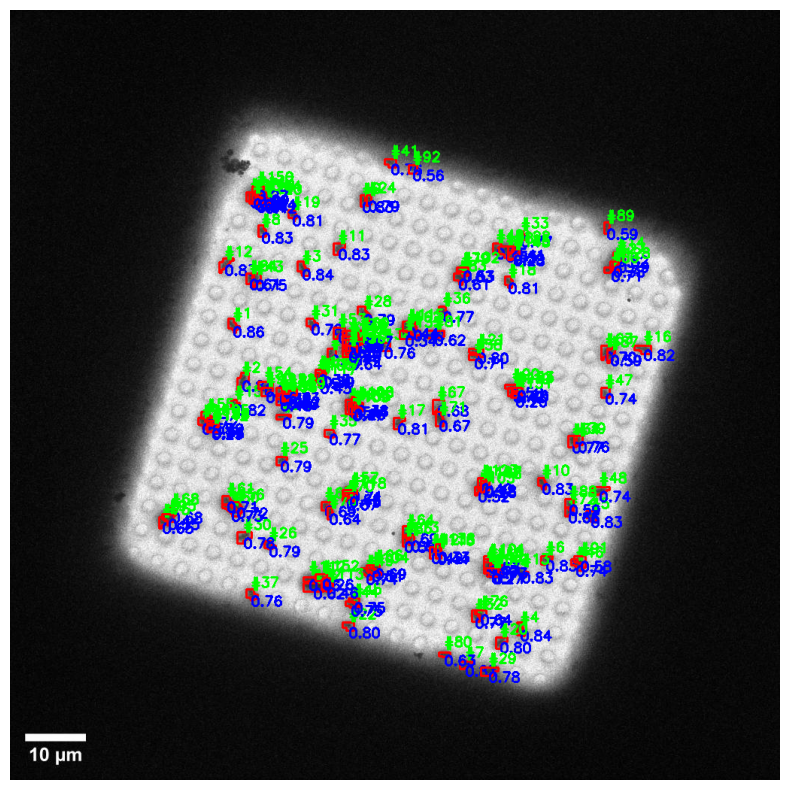

In [6]:
######### Predict on test set and get quantitative properties like area, boundry boxes, prediction confidence of bacteria in pixels and nm PER IMAGE

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ultralytics import YOLO
from skimage.measure import regionprops, label

# -----------------------------
# Paths
# -----------------------------
MODEL_PATH ="/content/Cryo-EM-Ultrastructures/models/best_FOV.pt"
IMAGE_PATH = '/content/Cryo-EM-Ultrastructures/Datasets/FOV/13s-MOPSsuc_dyn_png.rf.a208bbaa86110b0d928056cba14fc34d.jpg'

# -----------------------------
# Conversion factor (nm per px)
# -----------------------------
ORIG_SIZE = 4096
RESIZED_SIZE = 1024
PIXEL_SIZE_NM = 30.9595
NM_PER_PX = (ORIG_SIZE / RESIZED_SIZE) * PIXEL_SIZE_NM

# -----------------------------
# Load model and run inference
# -----------------------------
model = YOLO(MODEL_PATH)
results = model(IMAGE_PATH, verbose=False)[0]

# Load original image
image = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
overlay = image_rgb.copy()

records = []

if results.masks is not None:
    masks = results.masks.data.cpu().numpy()   # (N, H, W)
    boxes = results.boxes.xyxy.cpu().numpy()   # bounding boxes
    confs = results.boxes.conf.cpu().numpy()   # confidence scores

    for i, (mask, box, conf) in enumerate(zip(masks, boxes, confs), start=1):
        mask_uint8 = (mask > 0.5).astype(np.uint8)  # binary mask

        # Regionprops (requires labeled mask)
        props = regionprops(label(mask_uint8))

        if len(props) > 0:
            prop = props[0]   # one region per mask

            # Extract pixel-based features
            area_px = prop.area
            perimeter_px = prop.perimeter
            eccentricity = prop.eccentricity
            solidity = prop.solidity

            # Convert to nanometers
            area_nm2 = area_px * (NM_PER_PX ** 2)
            perimeter_nm = perimeter_px * NM_PER_PX

            # Centroid (x,y)
            cx, cy = prop.centroid[::-1]

            # Draw contour in red
            contours, _ = cv2.findContours((mask_uint8*255), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(overlay, contours, -1, (255, 0, 0), 2)

            # Label with ID and confidence
            cv2.putText(overlay, f"#{i}", (int(cx), int(cy)-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.putText(overlay, f"{conf:.2f}", (int(cx), int(cy)+15),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

            # Save to dataframe
            records.append({
                "Bacterium_ID": i,
                "Confidence": float(conf),
                "Centroid_X": float(cx),
                "Centroid_Y": float(cy),
                "BBox_X1": float(box[0]),
                "BBox_Y1": float(box[1]),
                "BBox_X2": float(box[2]),
                "BBox_Y2": float(box[3]),
                "Area_px2": area_px,
                "Area_nm2": area_nm2})

# -----------------------------
# DataFrame
# -----------------------------
df = pd.DataFrame(records)
display(df.head())

# -----------------------------
# Show overlay
# -----------------------------
plt.figure(figsize=(10, 10))
plt.imshow(overlay)
plt.axis("off")
plt.show()

In [7]:
######### Repeat for all images in the test folder

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob, os
from ultralytics import YOLO
from skimage.measure import regionprops, label

# -----------------------------
# Paths
# -----------------------------
MODEL_PATH = "/content/Cryo-EM-Ultrastructures/models/best_FOV.pt"
IMAGE_DIR = "/content/Cryo-EM-Ultrastructures/Datasets/FOV"
output_folder = "/content/Cryo-EM-Ultrastructures/Datasets/FOV/output"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)


# -----------------------------
# Conversion factor (nm per px)
# -----------------------------
ORIG_SIZE = 4096
RESIZED_SIZE = 1024
PIXEL_SIZE_NM = 30.9595
NM_PER_PX = (ORIG_SIZE / RESIZED_SIZE) * PIXEL_SIZE_NM

# -----------------------------
# Load YOLO model
# -----------------------------
model = YOLO(MODEL_PATH)

# -----------------------------
# Process all images
# -----------------------------
image_paths = glob.glob(os.path.join(IMAGE_DIR, "*.[pj][np]g")) + \
              glob.glob(os.path.join(IMAGE_DIR, "*.tif")) + \
              glob.glob(os.path.join(IMAGE_DIR, "*.tiff"))

for img_path in image_paths:
    base = os.path.splitext(os.path.basename(img_path))[0]
    folder = os.path.dirname(img_path)
    print(f"Processing {base} ...")

    # Run YOLO inference
    results = model(img_path, verbose=False)[0]

    # Load original image
    image = cv2.imread(img_path)
    if image is None:
        print(f"Could not read {img_path}, skipping.")
        continue
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    overlay = image_rgb.copy()

    records = []

    if results.masks is not None:
        masks = results.masks.data.cpu().numpy()
        boxes = results.boxes.xyxy.cpu().numpy()
        confs = results.boxes.conf.cpu().numpy()

        for i, (mask, box, conf) in enumerate(zip(masks, boxes, confs), start=1):
            mask_uint8 = (mask > 0.5).astype(np.uint8)

            props = regionprops(label(mask_uint8))
            if len(props) == 0:
                continue

            prop = props[0]

            # Pixel-based features
            area_px = prop.area
            perimeter_px = prop.perimeter
            eccentricity = prop.eccentricity
            solidity = prop.solidity

            # Convert to nm
            area_nm2 = area_px * (NM_PER_PX ** 2)
            perimeter_nm = perimeter_px * NM_PER_PX

            # Centroid
            cx, cy = prop.centroid[::-1]

            # Draw contour and ID on overlay
            contours, _ = cv2.findContours((mask_uint8*255), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(overlay, contours, -1, (255, 0, 0), 2)
            cv2.putText(overlay, f"#{i}", (int(cx), int(cy)-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.putText(overlay, f"{conf:.2f}", (int(cx), int(cy)+15),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

            # Save record
            records.append({
                "Image": base,
                "Bacterium_ID": i,
                "Confidence": float(conf),
                "Centroid_X": float(cx),
                "Centroid_Y": float(cy),
                "BBox_X1": float(box[0]),
                "BBox_Y1": float(box[1]),
                "BBox_X2": float(box[2]),
                "BBox_Y2": float(box[3]),
                "Area_px2": area_px,
                "Area_nm2": area_nm2})

    # Save per-image CSV
    df = pd.DataFrame(records)
    csv_path = os.path.join(output_folder, f"{base}_FOV_metrics.csv")
    df.to_csv(csv_path, index=False)

    # Save overlay figure
    plt.figure(figsize=(10, 10))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"{base} - YOLO Segmentation")
    plt.tight_layout()
    overlay_path = os.path.join(output_folder, f"{base}_overlay.png")
    plt.savefig(overlay_path, dpi=150)
    plt.close()

Processing 2-MOPSglu_dyn_png.rf.2c57139c92ca0088686a7b0c53f6239a ...
Processing 3-MOPSglu_dyn_png.rf.03a318970b9ef7f2ad0e3f4fa08d51e9 ...
Processing 8r-R2A_dyn_png.rf.29b093ff0e323c61575d050c44d03d9d ...
Processing 15r-R2A_dyn_png.rf.fd0ac421729f3ffc9ce1e2072e08e3c7 ...
Processing 13s-MOPSsuc_dyn_png.rf.a208bbaa86110b0d928056cba14fc34d ...
